In [1]:
import pandas as pd # to import data and othe functions
import numpy as np # to do mathametical operation
import string #for text pre-processing
from nltk.corpus import stopwords #for removing stopwords
import re #Regular expression operations
import xgboost as xgb #For predicting the values
from sklearn.model_selection import KFold #for cross validations(CV)
from sklearn import metrics #for getting CV score
from collections import Counter #counting of words in the texts
import operator
from nltk import ngrams
import nltk # major package for language processing
from nltk import word_tokenize # for toconizing
import matplotlib.pyplot as plt

C:\Users\DX\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
training_df = pd.read_csv('train.csv')
testing_df=pd.read_csv('test.csv')

In [3]:
training_df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [4]:
# checking the contribution of each author
training_author_df=training_df.groupby('author',as_index=False).count()
training_author_df

,author,id,text
0,EAP,7900,7900
1,HPL,5635,5635
2,MWS,6044,6044


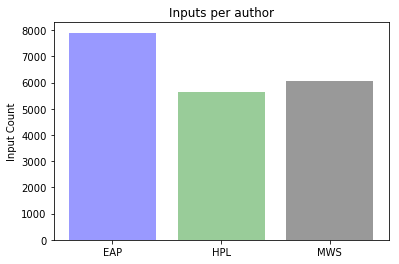

In [5]:
objects = training_author_df['author']  #storing values of authors in objects
y_pos = np.arange(len(objects)) #creating numpy array for the count of authors
ids = training_author_df['id'] #assignig values of id for each author
 
plt.bar(y_pos, ids, align='center', alpha=0.4,color = 'bgk') #basic configuration for bar chart
plt.xticks(y_pos, objects) #assigning Labels to be displayed on X-axis
plt.ylabel('Input Count') 
plt.title('Inputs per author')
 
plt.show()

Starting preprocessing of text 

In [6]:
# taking in the first field
text_string=training_df.iloc[0]['text']
text_string

'This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.'

In [7]:
#1st lecvel of cleaning. Cleaning punctuation 
string.punctuation


'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# creating function to remove punctuation.
def remove_punctuation_from_string(string1):
    string1=string1.lower() # changing to lower case
    translation_table=dict.fromkeys(map(ord,string.punctuation),' ')
    string2=string1.translate(translation_table)
    return string2
print('After processing')
test_string=remove_punctuation_from_string(text_string)
test_string


After processing


'this process  however  afforded me no means of ascertaining the dimensions of my dungeon  as i might make its circuit  and return to the point whence i set out  without being aware of the fact  so perfectly uniform seemed the wall '

In [9]:
# now removing stop words from the string
training_df.head(5)


,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [10]:
def remove_stopwords_from_string(string1):
    pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*') #compiling all stopwords.
    string2 = pattern.sub('', string1) #replacing the occurrences of stopwords in string1
    return string2

print('After processing')
test_string = remove_stopwords_from_string(test_string)
test_string

After processing


'process  however  afforded means ascertaining dimensions dungeon  might make circuit  return point whence set without aware fact  perfectly uniform seemed wall '

In [11]:
# creating backup
training_df['text_backup']=training_df['text']
testing_df['text_backup']=testing_df['text']

In [12]:
# usiing apply to remove the unwanted words.
training_df['text']=training_df['text'].apply(lambda x: remove_punctuation_from_string(x))
training_df['text']=training_df['text'].apply(lambda x: remove_stopwords_from_string(x))
testing_df['text']=testing_df['text'].apply(lambda x: remove_stopwords_from_string(x))
testing_df['text']=testing_df['text'].apply(lambda x: remove_punctuation_from_string(x))


In [13]:
training_df.head()

,id,text,author,text_backup
0,id26305,process however afforded means ascertaining ...,EAP,"This process, however, afforded me no means of..."
1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling...
2,id11008,left hand gold snuff box capered hill cuttin...,EAP,"In his left hand was a gold snuff box, from wh..."
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,How lovely is spring As we looked from Windsor...
4,id12958,finding nothing else even gold superintenden...,HPL,"Finding nothing else, not even gold, the Super..."


In [14]:
# now I have cleaned the data. Its time for processing the data and create features from it.
#Feature 1 : Finding total words in the sentance
training_df['feature1']=training_df['text_backup'].apply(lambda x: len(str(x).split()))
testing_df['feature1']=testing_df['text_backup'].apply(lambda x: len(str(x).split()))


In [15]:
#Feature 2 : Counting no of charecter in a variable
training_df['feature2']=training_df['text_backup'].apply(lambda x: len(str(x)))
testing_df['feature2']=training_df['text_backup'].apply(lambda x: len(str(x)))

In [16]:
#Feature 3 : Avg leangth of words used in the sentance.
training_df['feature3']=training_df['feature2']/training_df['feature1']
testing_df['feature3']=testing_df['feature2']/testing_df['feature1']

In [21]:
# Feature 4: Count total stop words  in a sentence.
stop_words=set(stopwords.words('english'))
training_df['Feature4']=training_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                                       if w in stop_words ]))
testing_df['Feature4']=testing_df['text_backup'].apply(lambda x: len([w for w in str(x).lower().split()
                                                                    if w in stop_words]))






In [17]:
#finding the words that are used the most 
all_text_without_sw= ''
for i in training_df.itertuples():
    all_text_without_sw = all_text_without_sw +str(i.text)
    #getting count of each word
    counts=Counter(re.findall(r"[\w']+", all_text_without_sw))
    #deleting from counts
    del counts["'"]
    # getting top 50 words
    sorted_x=dict(sorted(counts.items(), key=operator.itemgetter(1), reverse = True)[:50])
    
# Feature 5 : The count of top words
    
training_df['Feature5']= training_df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                                     if w in sorted_x]))
    
    
testing_df['Feature5']= training_df['text'].apply(lambda x: len([w for w in str(x).lower.split()
                                                                if w in sorted_x]))


AttributeError: 'builtin_function_or_method' object has no attribute 'split'

In [28]:
training_df.head()

,id,text,author,text_backup,feature1,feature2,feature3,Feature4,Feature5
0,id26305,process however afforded means ascertaining ...,EAP,"This process, however, afforded me no means of...",41,231,5.634146,19,3
1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling...,14,71,5.071429,8,2
2,id11008,left hand gold snuff box capered hill cuttin...,EAP,"In his left hand was a gold snuff box, from wh...",36,200,5.555556,16,0
3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,How lovely is spring As we looked from Windsor...,34,206,6.058824,13,1
4,id12958,finding nothing else even gold superintenden...,HPL,"Finding nothing else, not even gold, the Super...",27,174,6.444444,11,1


In [27]:
training_df.to_csv('backup f1.csv')

In [32]:
testing_df.to_csv('testbackup f1.csv')

In [37]:
# Feature 6 : least used words
reverted_x=dict(sorted(counts.items(), key=operator.itemgetter(1))[:1000])

training_df['Feature6']=training_df['text'].apply(lambda x: len ([w for w in str(x).lower().split() 
                                                                  if w in reverted_x]))

testing_df['Feature6']=training_df['text'].apply(lambda x: len([w for w in str(x).lower().split()
                                                               if w in reverted_x]))



In [39]:
# Feature 7 : Find the total no of puntuation
training_df['Feature7']= training_df['text_backup'].apply(lambda x: len([w for w in str(x) 
                                                                         if w in string.punctuation]))
testing_df['Feature7']=testing_df['text_backup'].apply(lambda x : len ([w for w in str(x) if w in string.punctuation]))

In [40]:
training_df.to_csv('backup f1.csv', )
testing_df.to_csv('testbackup f1.csv')



In [3]:
training_df = pd.read_csv('backup f1.csv',encoding='latin-1')
testing_df=pd.read_csv('testbackup f1.csv', encoding='latin-1')

In [4]:
training_df.head()

,Unnamed: 0,id,text,author,text_backup,feature1,feature2,feature3,Feature4,Feature5,Feature6,Feature7
0,0,id26305,process however afforded means ascertaining ...,EAP,"This process, however, afforded me no means of...",41,231,5.634146,19,3,0,7
1,1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling...,14,71,5.071429,8,2,0,1
2,2,id11008,left hand gold snuff box capered hill cuttin...,EAP,"In his left hand was a gold snuff box, from wh...",36,200,5.555556,16,0,1,5
3,3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,How lovely is spring As we looked from Windsor...,34,206,6.058824,13,1,0,4
4,4,id12958,finding nothing else even gold superintenden...,HPL,"Finding nothing else, not even gold, the Super...",27,174,6.444444,11,1,0,4


In [12]:
#Feature-8: Count of UPPER case words.

training_df['Feature8']=training_df['text'].apply(lambda x: len([w for w in str(x).replace('I','i')
                                                                 .replace('A','a').split() if w.isupper()==True])) 
testing_df['Feature8']=testing_df['text'].apply(lambda x: len ([ w for w in str(x).replace('I','i')
                                                                 .replace('A','a').split() if w.upper==True]))




In [13]:
#Feature-9: Count of Title case words

training_df['Feature9']= training_df['text'].apply(lambda x: len([w for w in str(x).replace('I','i')
                                                                  .replace('A','a').split() if w.istitle==True]) )
testing_df['Feature9']=testing_df['text'].apply(lambda x: len([w for w in str(x).replace('I','i')
                                                              .replace('A','a').split() if w.istitle==True]))

In [22]:
starting_words = sorted(list(map(lambda word : word[:2],filter(lambda word :
                                                               len(word) > 3,all_text_without_sw.split()))))
sw_counts = Counter(starting_words)
top_30_sw = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])



#Feature-10: Count of (Most words start with)
training_df['Feature_10'] = training_df['text'].apply(lambda x: 
                                                      len([w for w in str(x).lower().split()
                                                           if w[:2] in top_30_sw and w not in stop_words]) )
testing_df['Feature_10'] = testing_df['text'].apply(lambda x: 
                                                    len([w for w in str(x).lower().split() 
                                                         if w[:2] in top_30_sw and w not in stop_words]) )



In [23]:
#Feature-11: Count of (Most words end with)
ending_words = sorted(list(map(lambda word : word[-2:],filter(lambda word : len(word) > 3,all_text_without_sw.split()))))
ew_counts = Counter(ending_words)
top_30_ew = dict(sorted(sw_counts.items(), key=operator.itemgetter(1),reverse=True)[:30])
training_df['Feature_11'] = training_df['text'].apply(lambda x: len([w for w in str(x).lower().split() 
                                                                     if w[:2] in top_30_ew and w not in stop_words]) )
testing_df['Feature_11'] = testing_df['text'].apply(lambda x: len([w for w in str(x).lower().split()
                                                                   if w[:2] in top_30_ew and w not in stop_words]) )

In [24]:
training_df.to_csv('backup f1.csv', )
testing_df.to_csv('testbackup f1.csv')

In [25]:
training_df.head()

,Unnamed: 0,id,text,author,text_backup,feature1,feature2,feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature_10,Feature_11
0,0,id26305,process however afforded means ascertaining ...,EAP,"This process, however, afforded me no means of...",41,231,5.634146,19,3,0,7,0,0,12,12
1,1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling...,14,71,5.071429,8,2,0,1,0,0,2,2
2,2,id11008,left hand gold snuff box capered hill cuttin...,EAP,"In his left hand was a gold snuff box, from wh...",36,200,5.555556,16,0,1,5,0,0,7,7
3,3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,How lovely is spring As we looked from Windsor...,34,206,6.058824,13,1,0,4,0,0,10,10
4,4,id12958,finding nothing else even gold superintenden...,HPL,"Finding nothing else, not even gold, the Super...",27,174,6.444444,11,1,0,4,0,0,7,7


In [46]:
training_df= pd.read_csv('backup f1.csv', encoding='latin-1')
testing_df=pd.read_csv('testbackup f1.csv', encoding='latin-1')

In [5]:
training_df.head()

,Unnamed: 0,Unnamed: 0.1,id,text,author,text_backup,feature1,feature2,feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature_10,Feature_11
0,0,0,id26305,process however afforded means ascertaining ...,EAP,"This process, however, afforded me no means of...",41,231,5.634146,19,3,0,7,0,0,12,12
1,1,1,id17569,never occurred fumbling might mere mistake,HPL,It never once occurred to me that the fumbling...,14,71,5.071429,8,2,0,1,0,0,2,2
2,2,2,id11008,left hand gold snuff box capered hill cuttin...,EAP,"In his left hand was a gold snuff box, from wh...",36,200,5.555556,16,0,1,5,0,0,7,7
3,3,3,id27763,lovely spring looked windsor terrace sixteen f...,MWS,How lovely is spring As we looked from Windsor...,34,206,6.058824,13,1,0,4,0,0,10,10
4,4,4,id12958,finding nothing else even gold superintenden...,HPL,"Finding nothing else, not even gold, the Super...",27,174,6.444444,11,1,0,4,0,0,7,7


In [47]:
training_df=training_df.drop(['Unnamed: 0.1','Unnamed: 0','id','text_backup','text'],1)

In [48]:
testing_df=testing_df.drop(['Unnamed: 0.1','Unnamed: 0','id','text_backup','text'],1)

In [14]:
training_df.head()

,author,feature1,feature2,feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature_10,Feature_11
0,EAP,41,231,5.634146,19,3,0,7,0,0,12,12
1,HPL,14,71,5.071429,8,2,0,1,0,0,2,2
2,EAP,36,200,5.555556,16,0,1,5,0,0,7,7
3,MWS,34,206,6.058824,13,1,0,4,0,0,10,10
4,HPL,27,174,6.444444,11,1,0,4,0,0,7,7


In [49]:
training_df['author'].value_counts()

EAP    7900
MWS    6044
HPL    5635
Name: author, dtype: int64

In [50]:
di = {'EAP': 0,'HPL':1, 'MWS':2}
training_df=training_df.replace({"author": di})
testing_df=testing_df.replace({"author": di})

In [51]:
testing_df=testing_df.replace({"author": di})

In [72]:
y=training_df['author']
X=training_df.drop(['author'],1)
y=pd.get_dummies(y)

In [88]:
y.head()

,0,1,2
0,1,0,0
1,0,1,0
2,1,0,0
3,0,0,1
4,0,1,0


In [89]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest=train_test_split(X,y, test_size=0.33, random_state=42)

In [91]:
#converting to matrix
#Xtrain=Xtrain.values
ytrain=ytrain.values
#Xtest=Xtest.values
ytest=ytest.values

# building the architecture of keras model



In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [26]:
classifier=Sequential() 
training_df.shape

(19579, 12)

In [85]:
classifier.add(Dense(units=10, kernel_initializer="uniform",activation='relu',input_dim=11))
classifier.add(Dense(units=8, kernel_initializer="uniform", activation='softmax'))
classifier.add(Dense(units=6, kernel_initializer="uniform", activation='relu'))
classifier.add(Dense(units=3, activation='softmax'))

In [93]:
classifier.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
classifier.fit(Xtrain,ytrain,batch_size=5, epochs=10)

Epoch 1/10
13117/13117 [==============================] - 7s - loss: 1.0873 - acc: 0.4050     
Epoch 2/10
13117/13117 [==============================] - 6s - loss: 1.0873 - acc: 0.4050     
Epoch 3/10
13117/13117 [==============================] - 6s - loss: 1.0873 - acc: 0.4050     
Epoch 4/10
13117/13117 [==============================] - 6s - loss: 1.0873 - acc: 0.4050     
Epoch 5/10
13117/13117 [==============================] - 6s - loss: 1.0874 - acc: 0.4050     
Epoch 6/10
13117/13117 [==============================] - 6s - loss: 1.0873 - acc: 0.4050     
Epoch 7/10
13117/13117 [==============================] - 6s - loss: 1.0874 - acc: 0.4050     
Epoch 8/10
13117/13117 [==============================] - 6s - loss: 1.0874 - acc: 0.4050     
Epoch 9/10
13117/13117 [==============================] - 6s - loss: 1.0874 - acc: 0.4050     
Epoch 10/10
13117/13117 [==============================] - 6s - loss: 1.0873 - acc: 0.4050     


In [94]:
from sklearn.ensemble import RandomForestClassifier

In [95]:
ry=training_df['author']
rX=training_df.drop(['author'],1)

In [96]:
rXtrain,rXtest,rytrain,rytest=train_test_split(rX,ry, test_size=0.33, random_state=42)




In [97]:
clf=RandomForestClassifier()
clf.fit(rXtrain,rytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [99]:
from sklearn.model_selection import cross_val_score
print(cross_val_score(clf, rXtrain, rytrain))

[ 0.44591813  0.43664227  0.42840805]
